# Analysis - exp66

- exp65 but with grad clipping

In [15]:
import os
import csv
import numpy as np
import torch as th
import pandas as pd

from glob import glob
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

matplotlib.rcParams.update({'font.size': 16})
matplotlib.rc('axes', titlesize=16)

from notebook_helpers import load_params
from notebook_helpers import load_monitored
from notebook_helpers import join_monitored
from notebook_helpers import score_summary

def load_data(path, model, run_index=None):
    runs = range(run_index[0], run_index[1]+1)
    exps = []
    for r in runs:
        file = os.path.join(path, f"run_{model}_{r}_monitor.csv".format(int(r)))
        try:
            mon = load_monitored(file)
        except FileNotFoundError:
            mon = None
        exps.append(mon)
    return exps

def load_hp(name):
    return pd.read_csv(name, index_col=False)

def find_best(hp, data, window, score="score"):
    scores = []
    for r, mon in enumerate(data):
        if mon is not None:
            full = mon[score]
            selected = full[window[0]:window[1]]
            x = np.mean(selected)
            scores.append(x)
        else:
            scores.append(np.nan)
    best = np.nanargmax(scores)

    return hp[best:best+1]

def find_worst(hp, data, window, score="score"):
    scores = []
    for r, mon in enumerate(data):
        if mon is not None:
            full = mon[score]
            selected = full[window[0]:window[1]]
            x = np.mean(selected)
            scores.append(x)
        else:
            scores.append(np.nan)
    best = np.nanargmin(scores)
    return hp[best:best+1]

# Load data

In [28]:
path = "/Users/qualia/Code/azad/data/wythoff/exp66/"

hp_66 = load_hp(os.path.join(path,"grid.csv"))

models = ["DQN_xy1", "DQN_xy2", "DQN_xy3", "DQN_xy4", "DQN_xy5"]
index = (0, 250)

In [29]:
hp_66[0:1]

,row_code,device_code,epsilon,gamma,learning_rate
0,0,0,0.1,0.1,0.0025


# Plots
## All parameter summary

How's it look overall.

### Timecourse

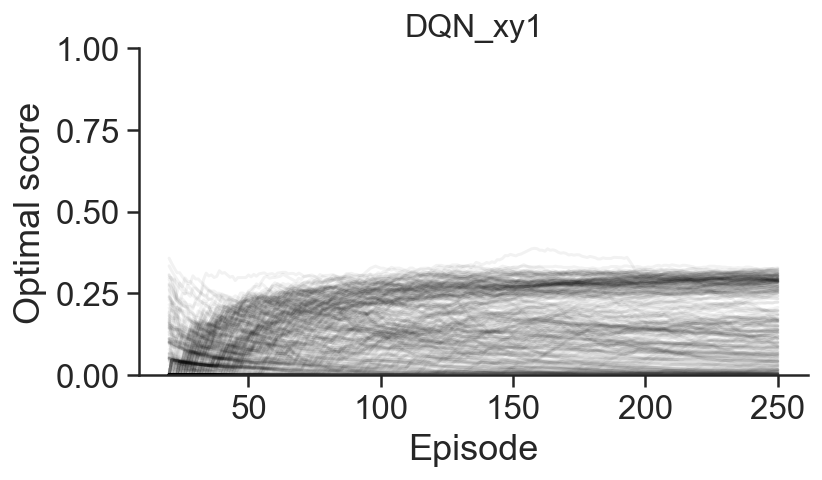

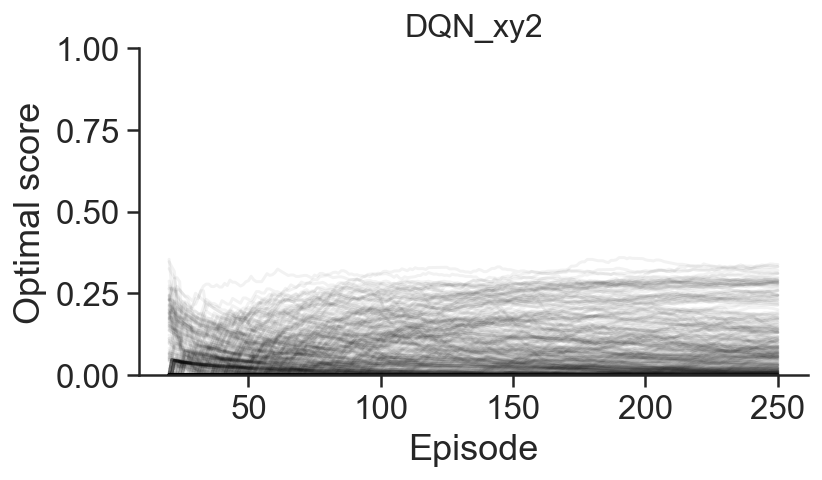

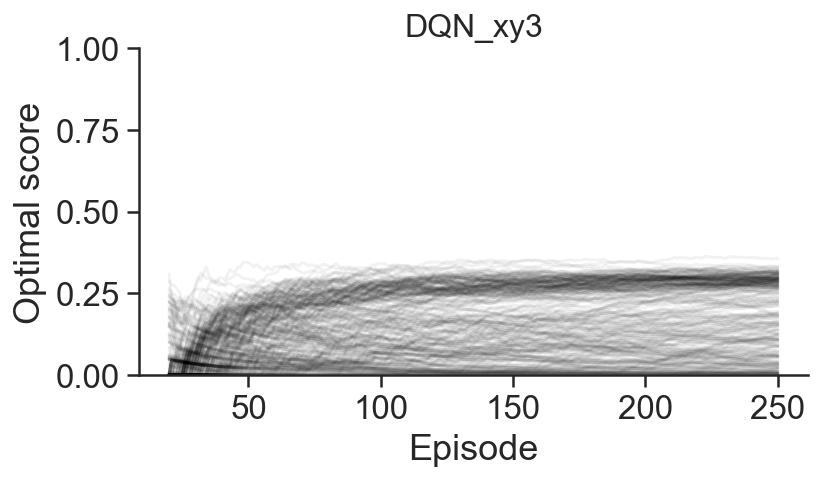

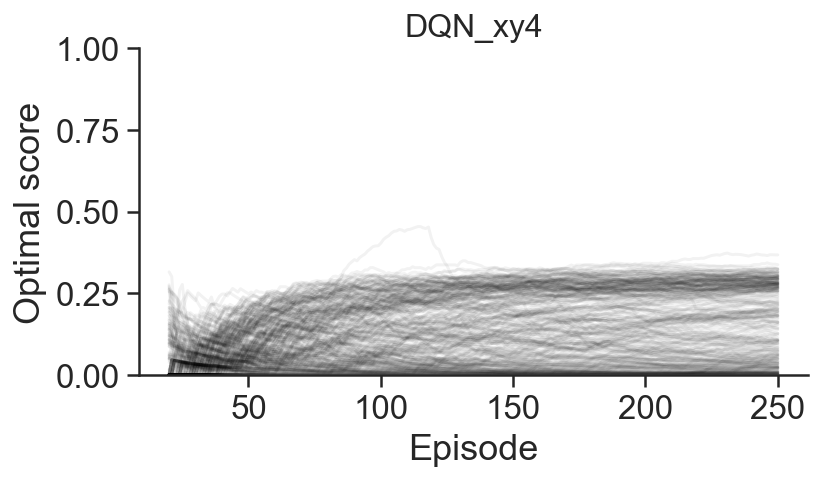

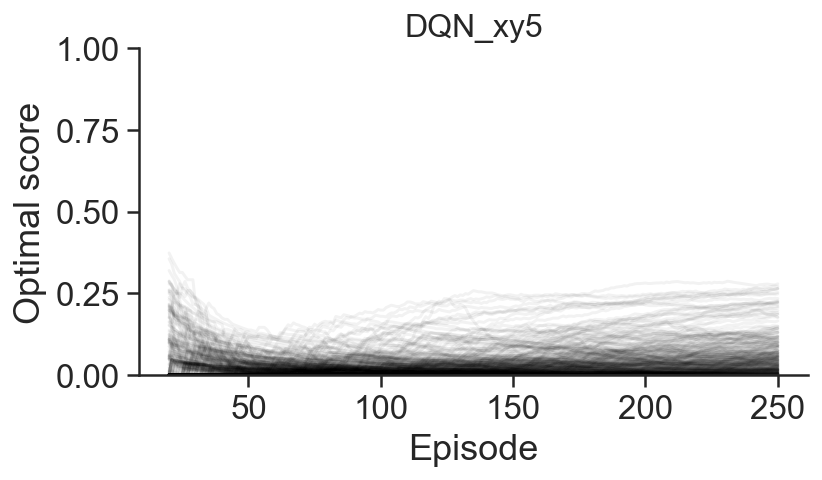

In [30]:
for model in models:
    data = load_data(path, model, run_index=index)
    plt.figure(figsize=(6, 3))
    for r, mon in enumerate(data):
        if mon is not None:
            _ = plt.plot(mon['episode'], mon['score'], color='black', alpha=0.05)
            _ = plt.ylim(0, 1)
    _ = plt.title(model)
    _ = plt.ylabel("Optimal score")
    _ = plt.xlabel("Episode")
    sns.despine()

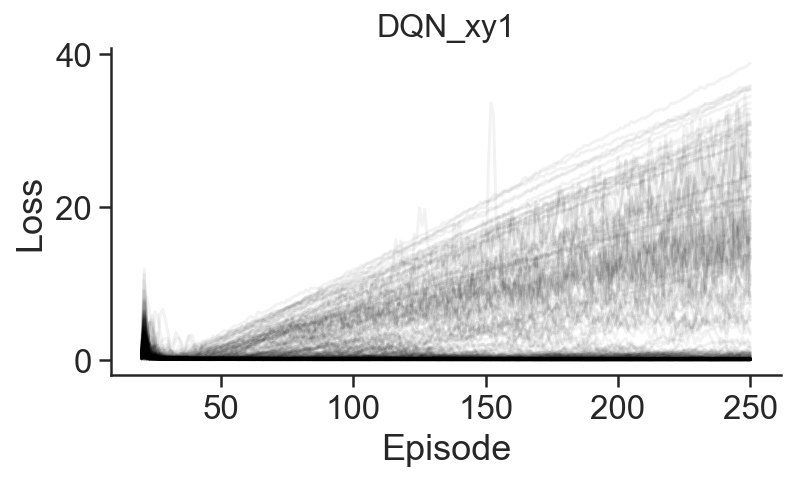

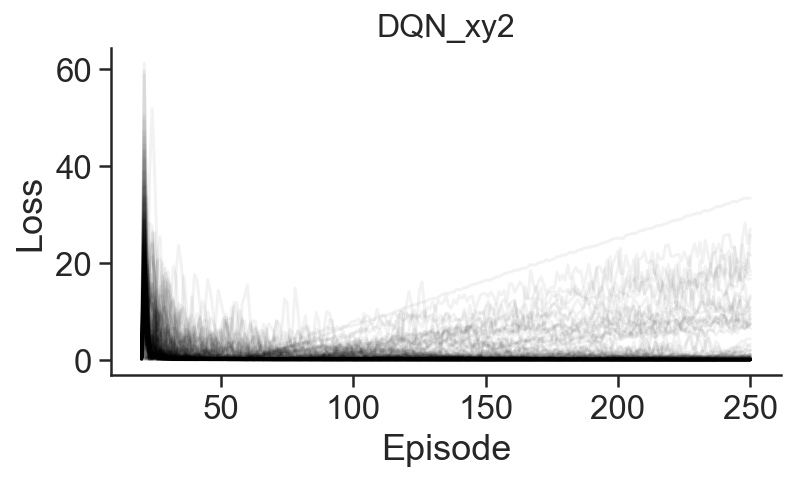

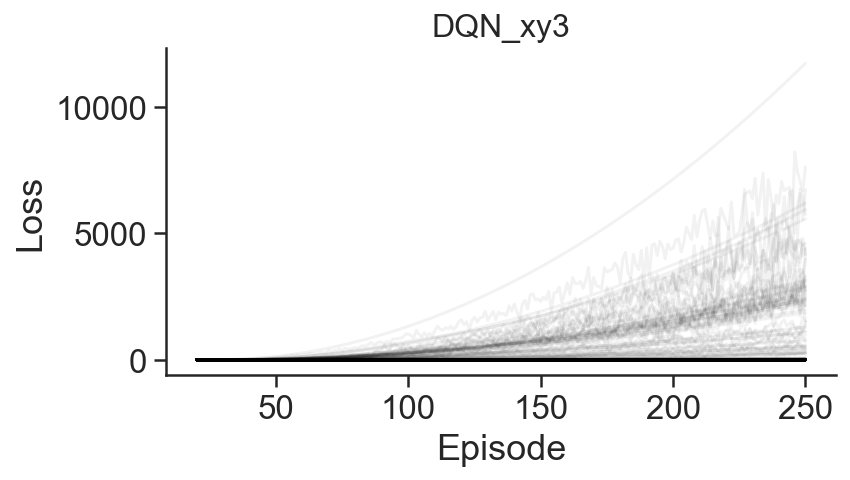

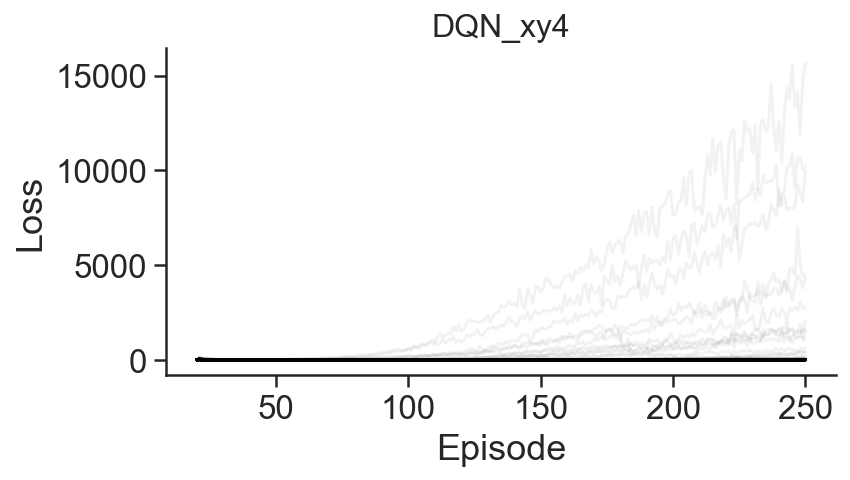

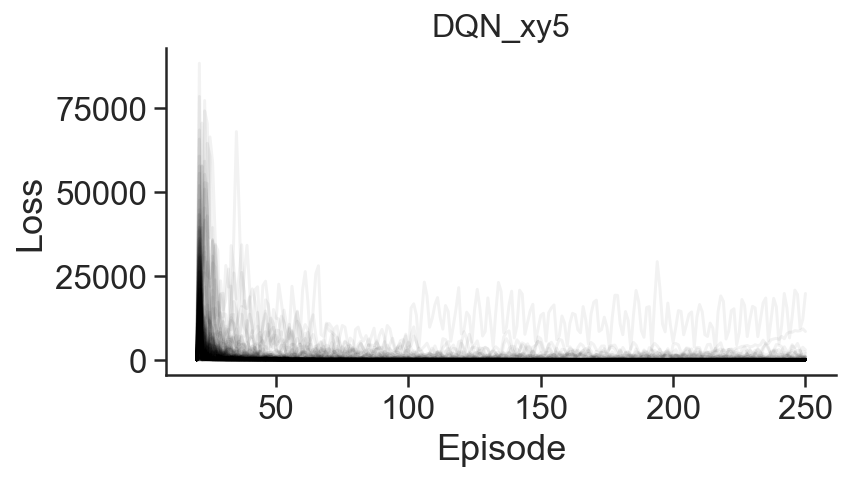

In [58]:
for model in models:
    data = load_data(path, model, run_index=index)
    plt.figure(figsize=(6, 3))
    for r, mon in enumerate(data):
        if mon is not None:
            _ = plt.plot(mon['episode'], mon['loss'], color='black', alpha=0.05)
#             _ = plt.ylim(0, 1)
    _ = plt.title(model)
    _ = plt.ylabel("Loss")
    _ = plt.xlabel("Episode")
    sns.despine()

## Plot loss dist

Want to split

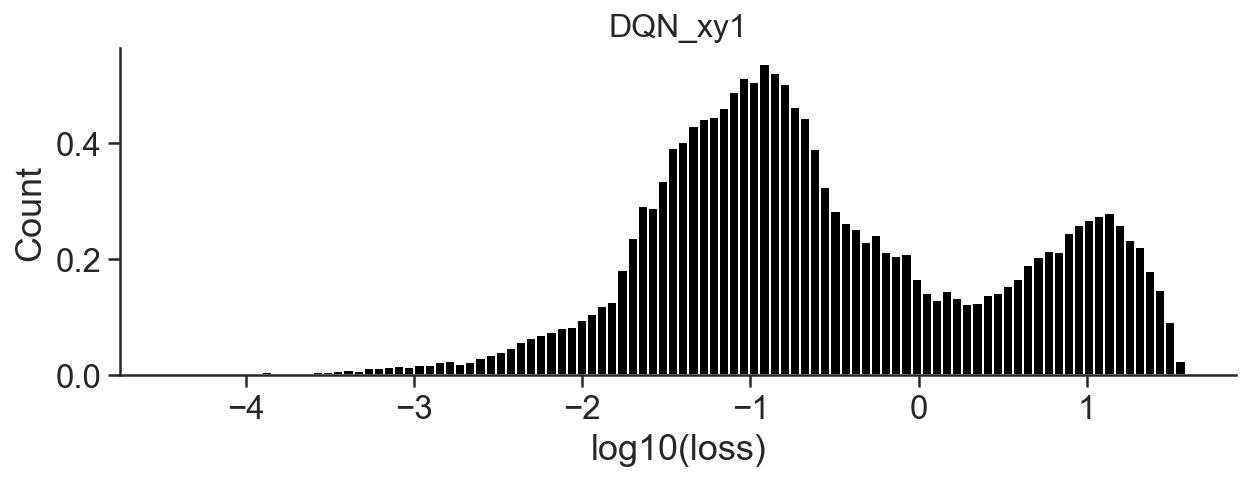

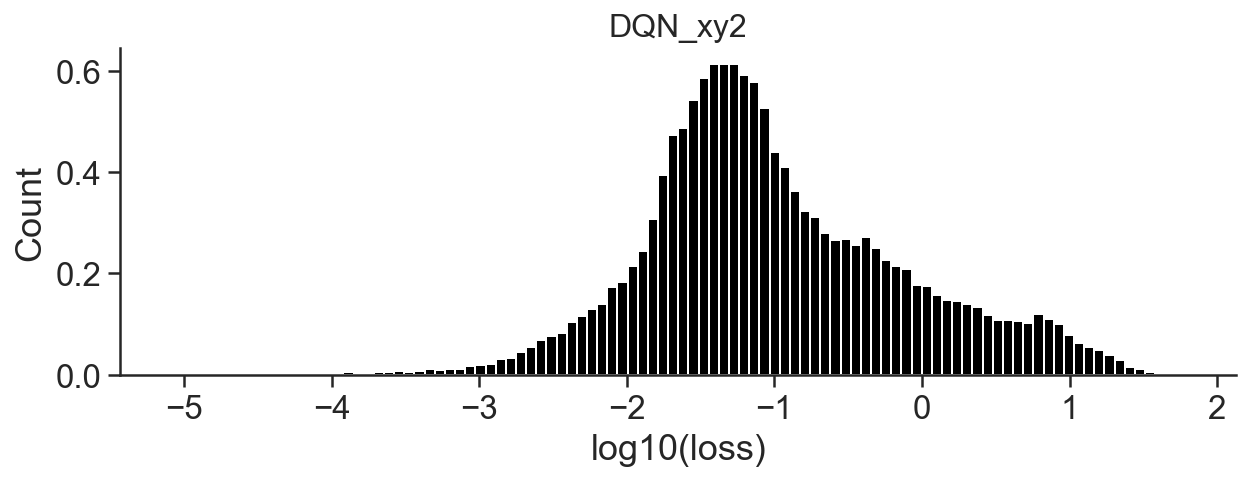

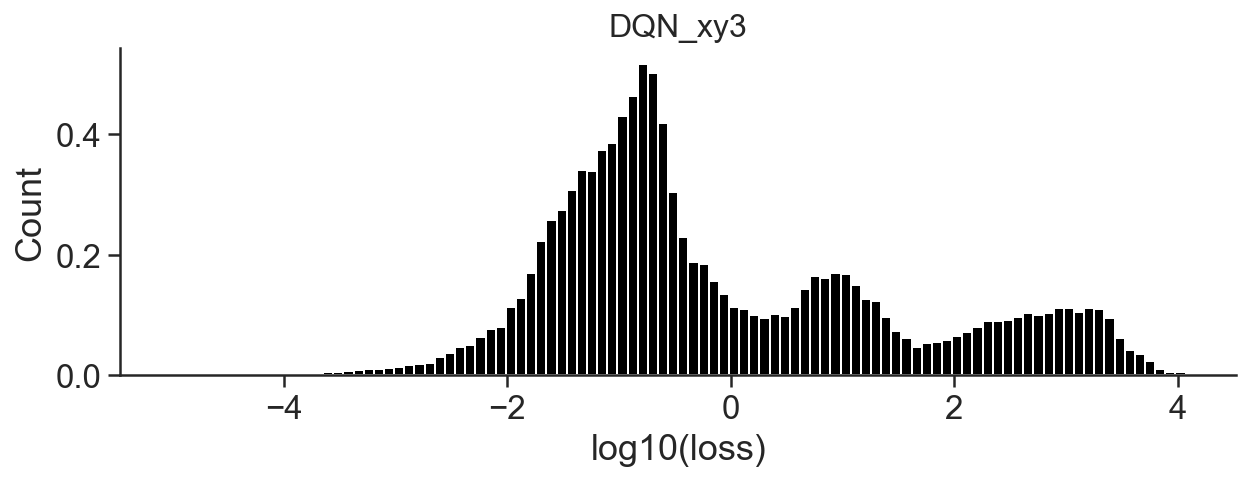

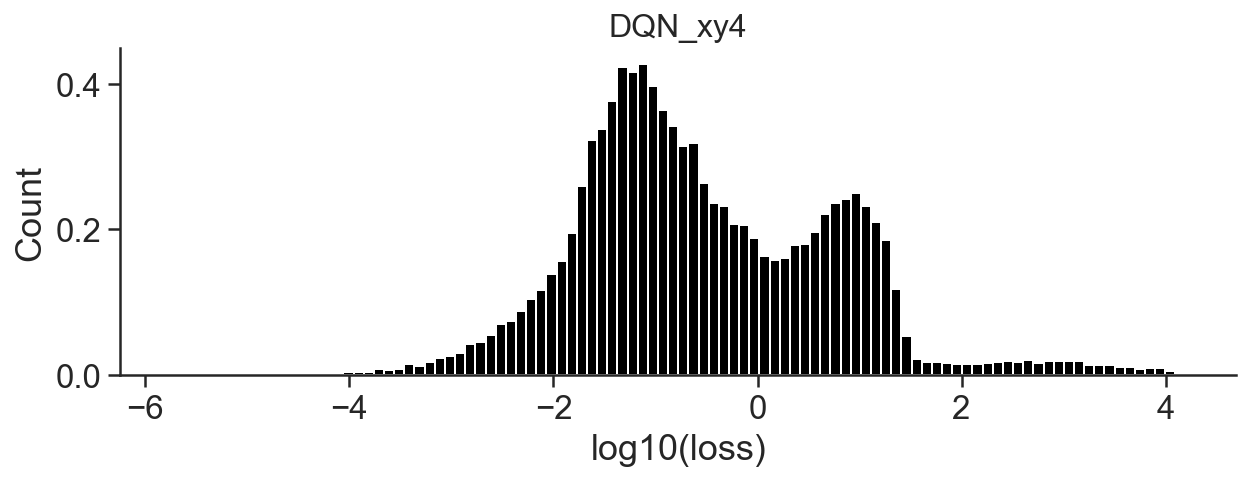

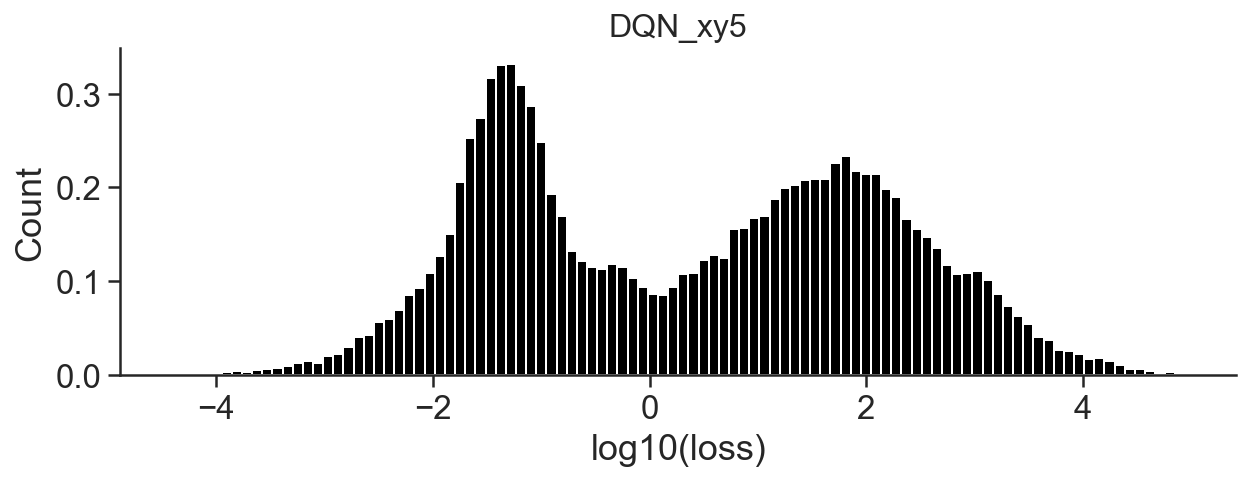

In [105]:
for model in models:
    losses = []
    data = load_data(path, model, run_index=index)
    for r, mon in enumerate(data):
        if mon is not None:
            losses.extend(mon["loss"])
    
    plt.figure(figsize=(10, 3))
    _ = plt.hist(np.log10(losses), color='black', bins=100, density=True)
    _ = plt.title(model)
    _ = plt.ylabel("Count")
    _ = plt.xlabel("log10(loss)")
    sns.despine()

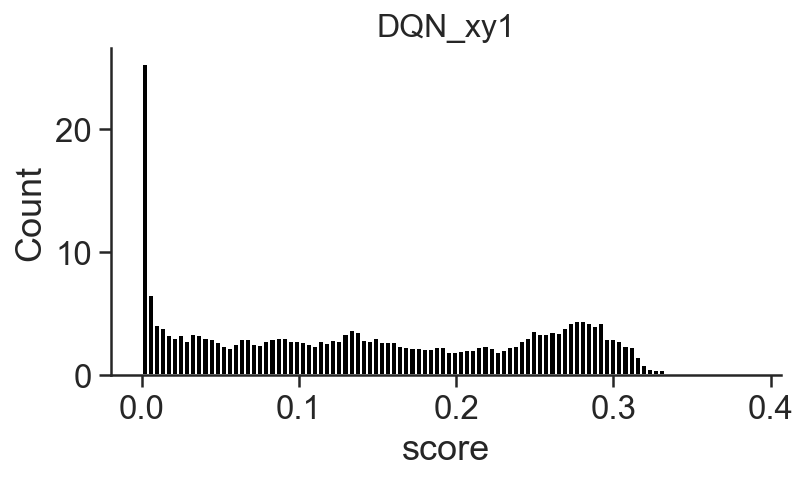

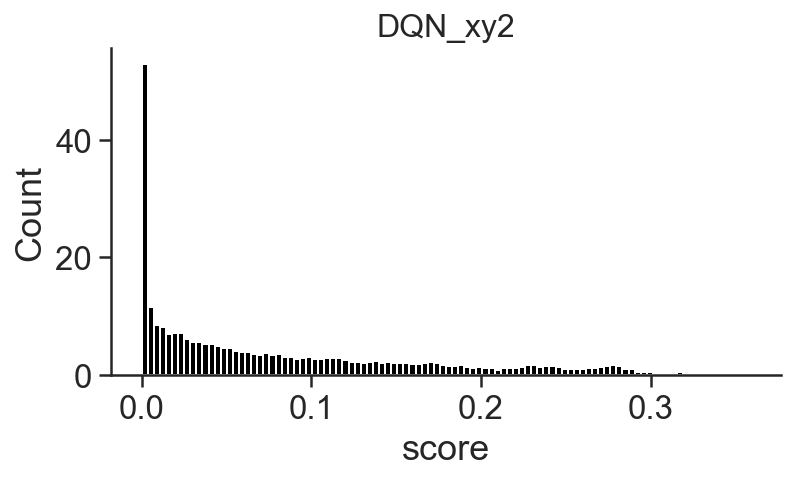

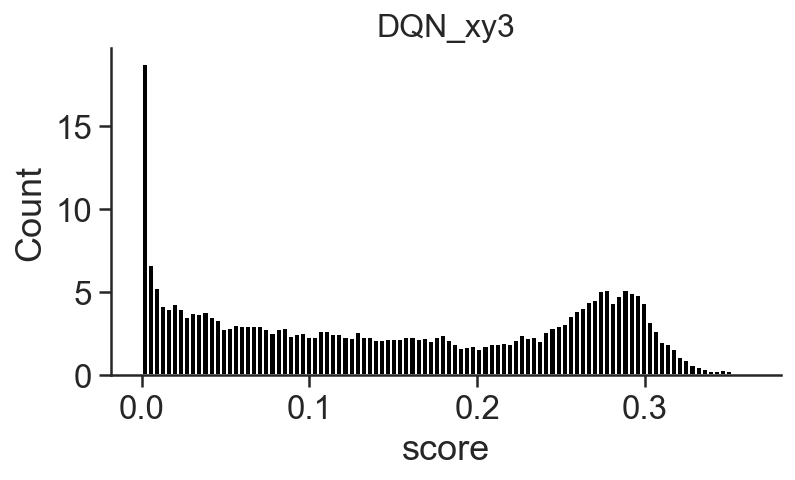

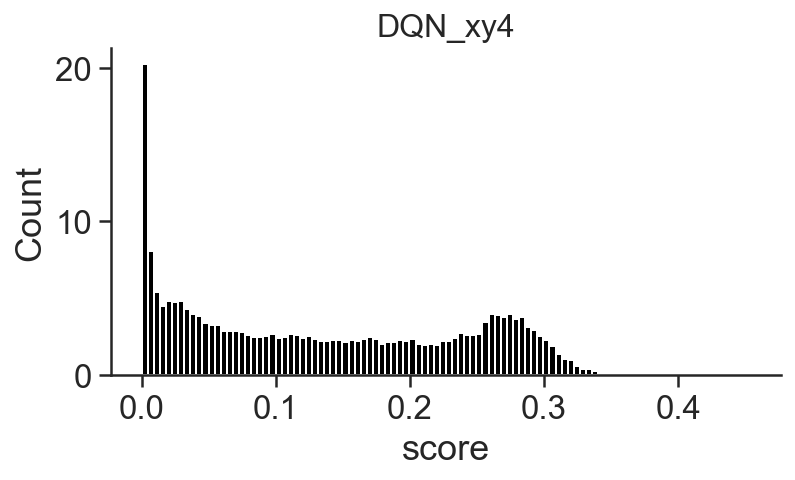

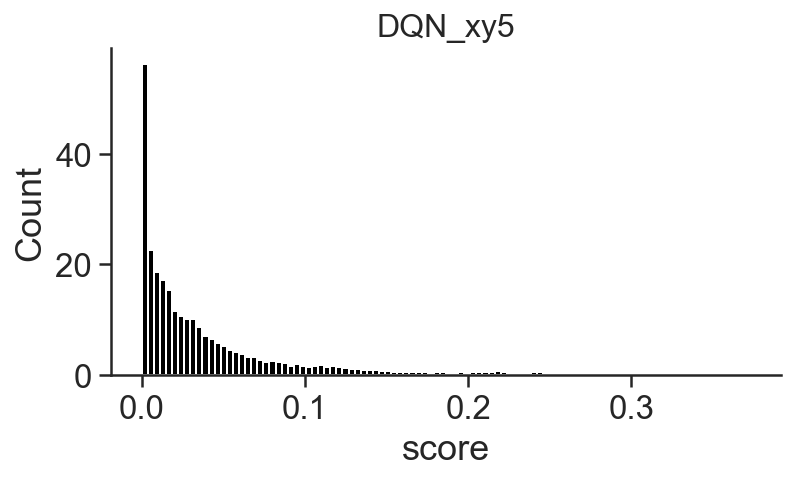

In [111]:
for model in models:
    scores = []
    data = load_data(path, model, run_index=index)
    for r, mon in enumerate(data):
        if mon is not None:
            scores.extend(mon["score"])
    
    plt.figure(figsize=(6, 3))
    _ = plt.hist(scores, color='black', bins=100, density=True)
    _ = plt.title(model)
    _ = plt.ylabel("Count")
    _ = plt.xlabel("score")
    sns.despine()

## Plot log(loss) by score

At the final trial

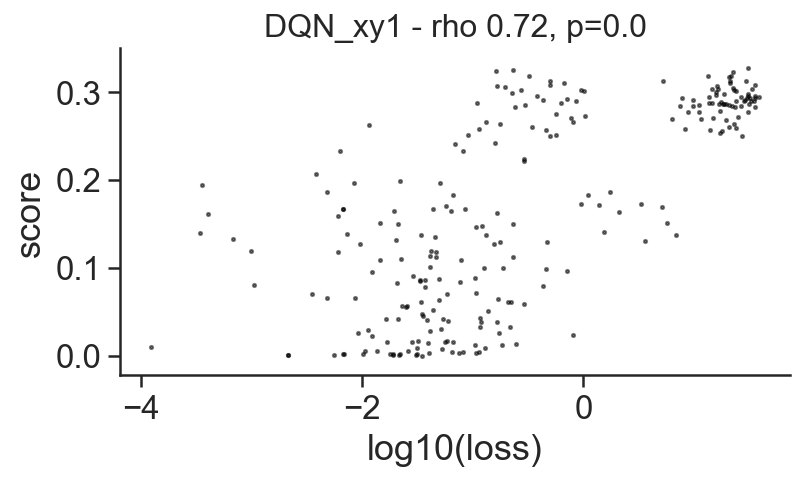

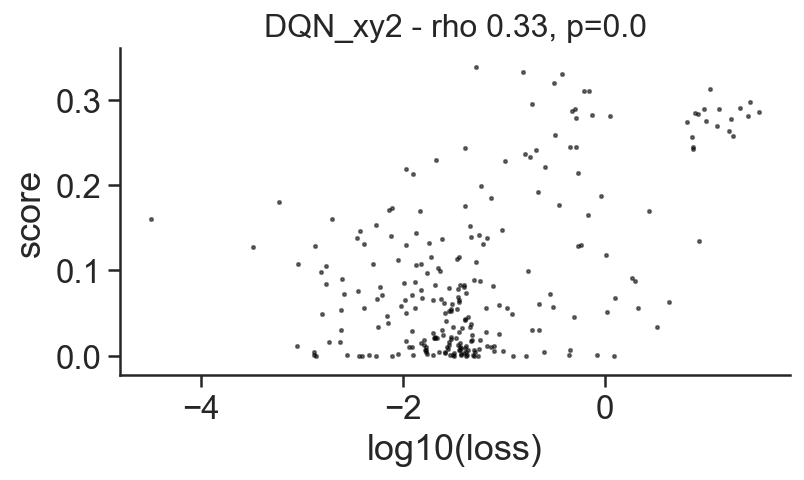

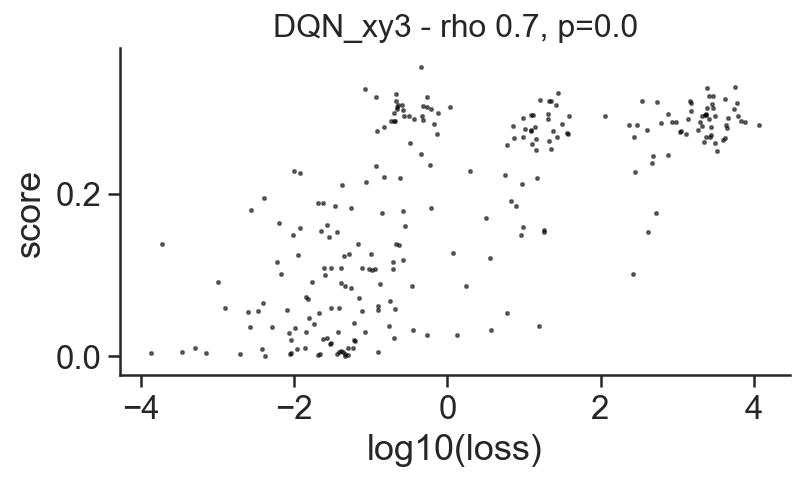

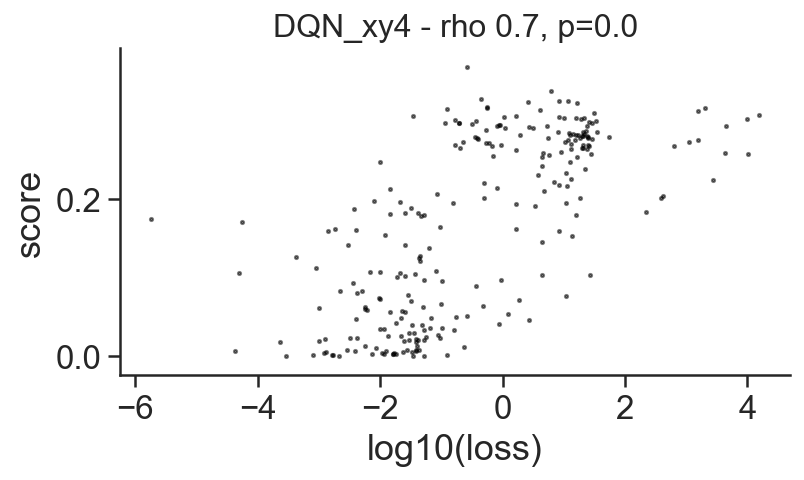

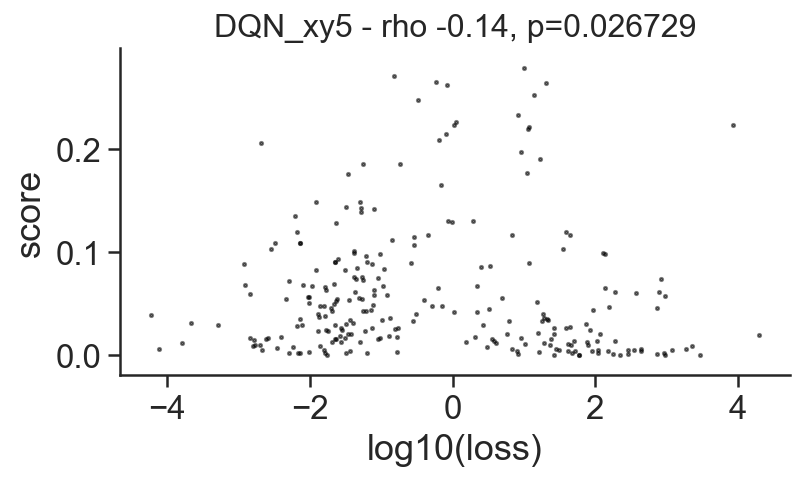

In [124]:
from scipy.stats import spearmanr

cutoff = 10
for model in models:
    losses = []
    scores = []
    data = load_data(path, model, run_index=index)
    for r, mon in enumerate(data):
        if mon is not None:
            loss = np.log10(mon["loss"][-1])
            if loss < cutoff:
                losses.append(loss)
                scores.append(mon["score"][-1])
            
    plt.figure(figsize=(6, 3))
    _ = plt.scatter(losses, scores, color='black', alpha=0.5, s=2.5)
    r, p = spearmanr(losses, scores)
    _ = plt.title(f"{model} - rho {np.round(r,2)}, p={np.round(p,6)}")
    _ = plt.xlabel("log10(loss)")
    _ = plt.ylabel("score")
    sns.despine()

# Find the best HP

## By score

In [51]:
for model in models:
    data = load_data(path, model, run_index=index)
    best_hp = find_best(hp_66, data, (200,250))
    print(f"{model}:\n{best_hp}\n---")

DQN_xy1:
     row_code  device_code  epsilon  gamma  learning_rate
128       128            0      0.1    0.3       0.143929
---
DQN_xy2:
   row_code  device_code  epsilon  gamma  learning_rate
9         9            1      0.1    0.1       0.047959
---
DQN_xy3:
    row_code  device_code  epsilon  gamma  learning_rate
32        32            0      0.1    0.1       0.164133
---
DQN_xy4:
    row_code  device_code  epsilon  gamma  learning_rate
11        11            3      0.1    0.1       0.058061
---
DQN_xy5:
    row_code  device_code  epsilon  gamma  learning_rate
72        72            0      0.1    0.2       0.113622
---


## By loss

In [52]:
for model in models:
    data = load_data(path, model, run_index=index)
    best_hp = find_worst(hp_66, data, (200,250), score='loss')
    print(f"{model}:\n{best_hp}\n---")

DQN_xy1:
    row_code  device_code  epsilon  gamma  learning_rate
62        62            2      0.1    0.2       0.063112
---
DQN_xy2:
     row_code  device_code  epsilon  gamma  learning_rate
217       217            1      0.1    0.5       0.088367
---
DQN_xy3:
     row_code  device_code  epsilon  gamma  learning_rate
174       174            2      0.1    0.4       0.123724
---
DQN_xy4:
     row_code  device_code  epsilon  gamma  learning_rate
187       187            3      0.1    0.4       0.189388
---
DQN_xy5:
     row_code  device_code  epsilon  gamma  learning_rate
156       156            0      0.1    0.4       0.032806
---


# Plot best

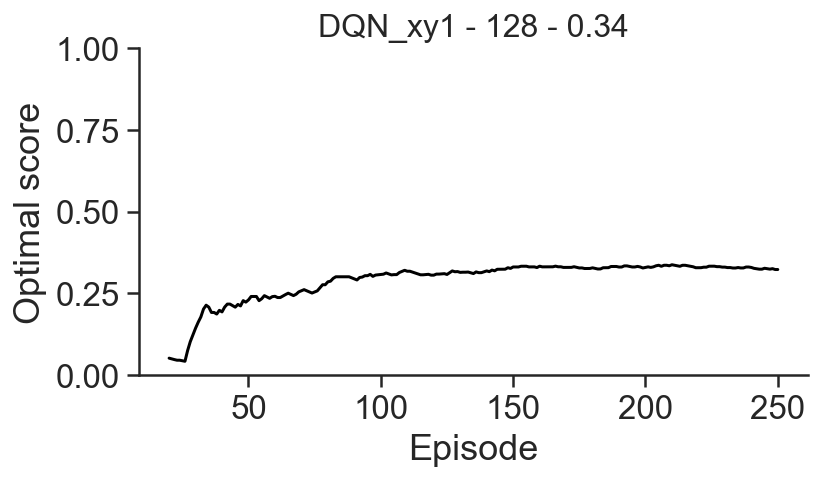

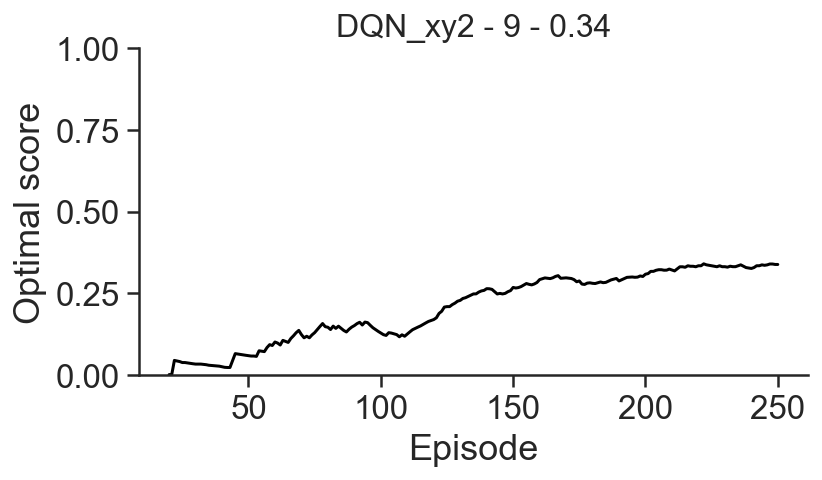

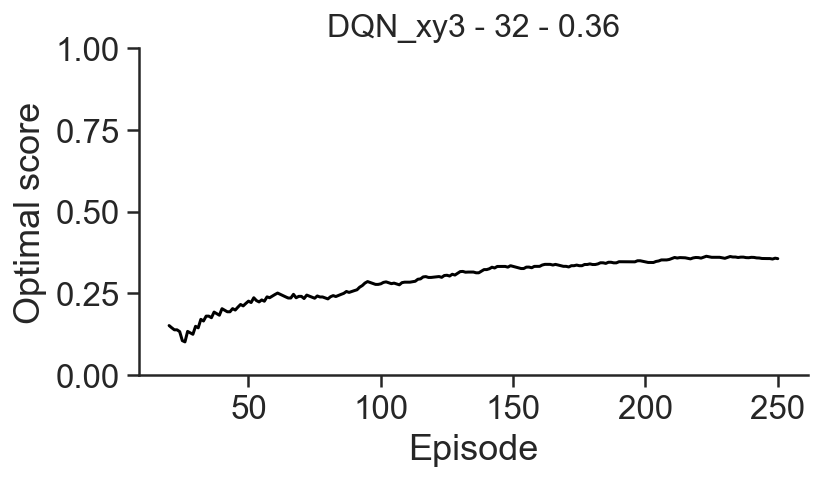

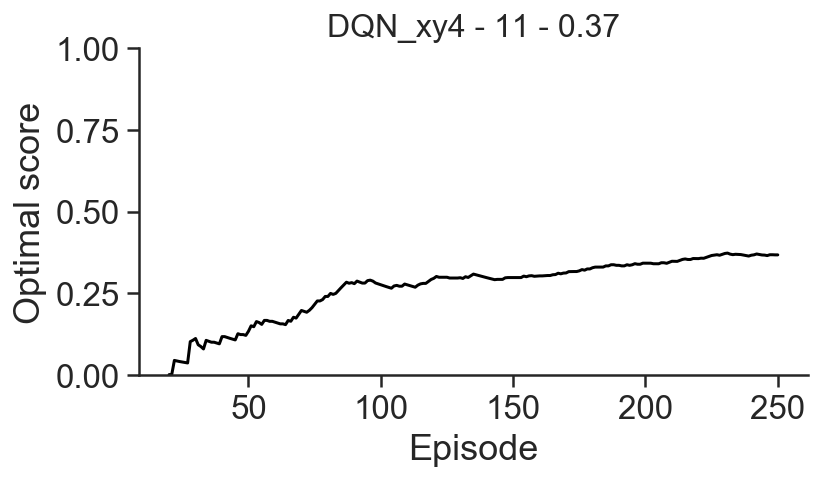

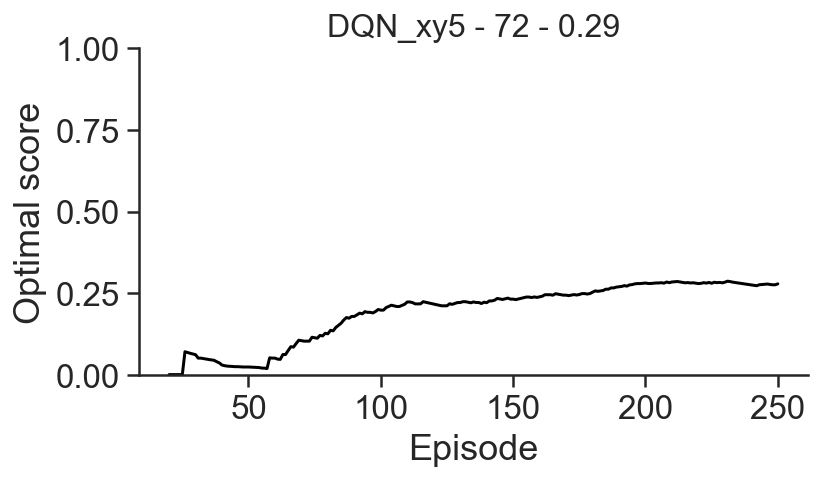

In [56]:
best_rows = [128, 9, 32, 11, 72]
# best_rows = [62, 217, 174, 187, 156]
for row, model in zip(best_rows, models):
    data = load_data(path, model, run_index=index)
    plt.figure(figsize=(6, 3))
    mon = data[row]
    _ = plt.plot(mon['episode'], mon['score'], color='black', alpha=1)
    _ = plt.title(f"{model} - {row} - {np.max(mon['score']).round(2)}")
    _ = plt.ylabel("Optimal score")
    _ = plt.xlabel("Episode")
    _ = plt.ylim(0, 1)
    sns.despine()

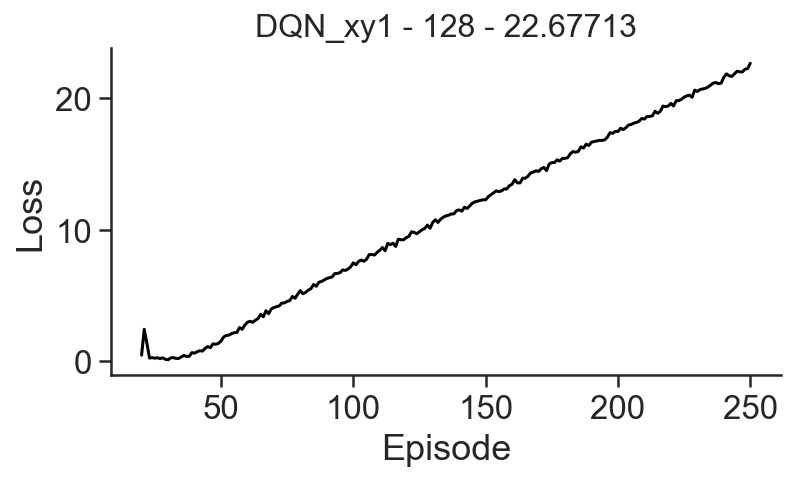

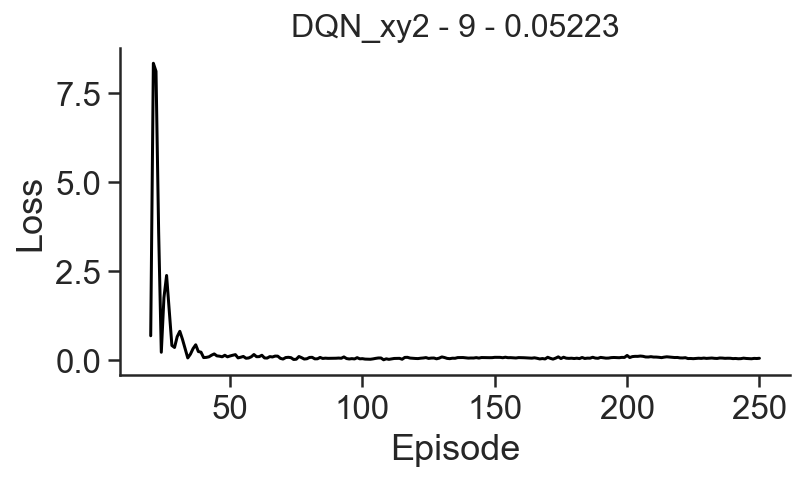

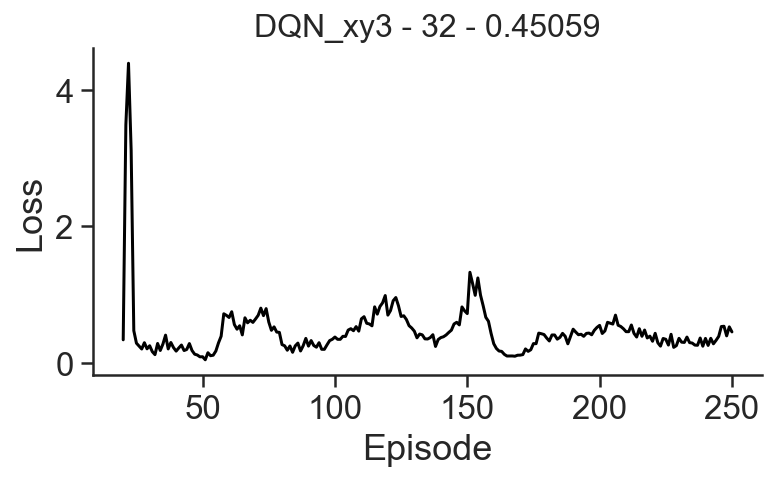

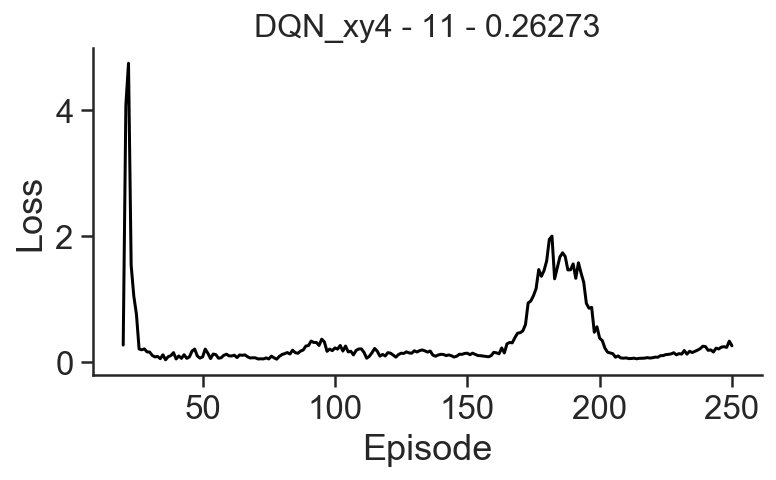

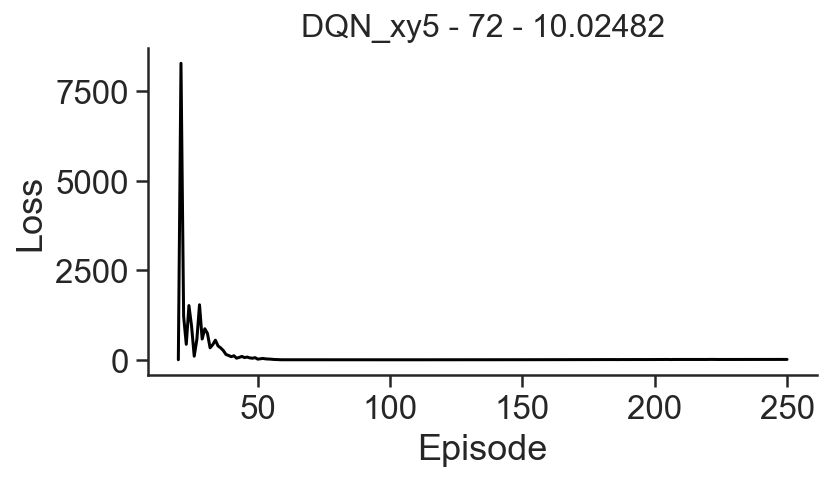

In [57]:
best_rows = [128, 9, 32, 11, 72]
# best_rows = [62, 217, 174, 187, 156]
for row, model in zip(best_rows, models):
    data = load_data(path, model, run_index=index)
    plt.figure(figsize=(6, 3))
    mon = data[row]
    _ = plt.plot(mon['episode'], mon['loss'], color='black', alpha=1)
    _ = plt.title(f"{model} - {row} - {np.round(mon['loss'][-1],5)}")
    _ = plt.ylabel("Loss")
    _ = plt.xlabel("Episode")
    sns.despine()

# Find worst HP

In [44]:
for model in models:
    data = load_data(path, model, run_index=index)
    print(model)
    best_hp = find_worst(hp_66, data, (200,250))

    print(f"{model}:\n{best_hp}\n---")

DQN_xy1
DQN_xy1:
     row_code  device_code  epsilon  gamma  learning_rate
200       200            0      0.1    0.5         0.0025
---
DQN_xy2
DQN_xy2:
    row_code  device_code  epsilon  gamma  learning_rate
76        76            0      0.1    0.2       0.133827
---
DQN_xy3
DQN_xy3:
     row_code  device_code  epsilon  gamma  learning_rate
210       210            2      0.1    0.5        0.05301
---
DQN_xy4
DQN_xy4:
     row_code  device_code  epsilon  gamma  learning_rate
205       205            1      0.1    0.5       0.027755
---
DQN_xy5
DQN_xy5:
     row_code  device_code  epsilon  gamma  learning_rate
185       185            1      0.1    0.4       0.179286
---


## Plot worst

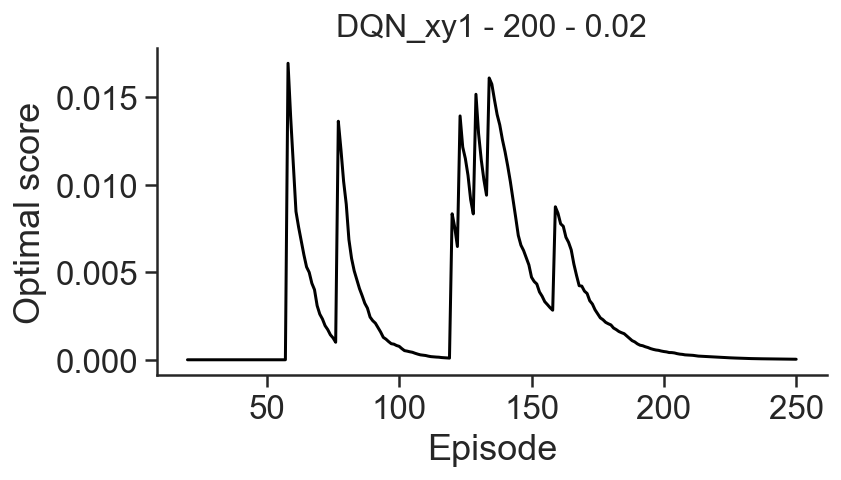

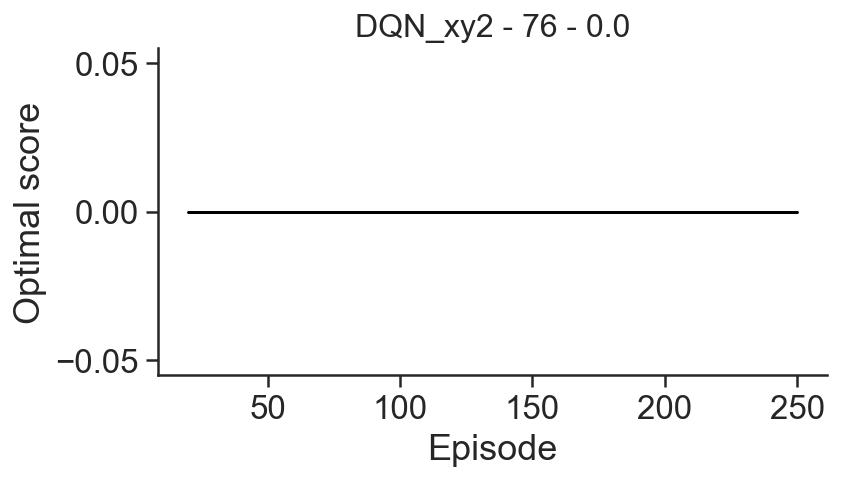

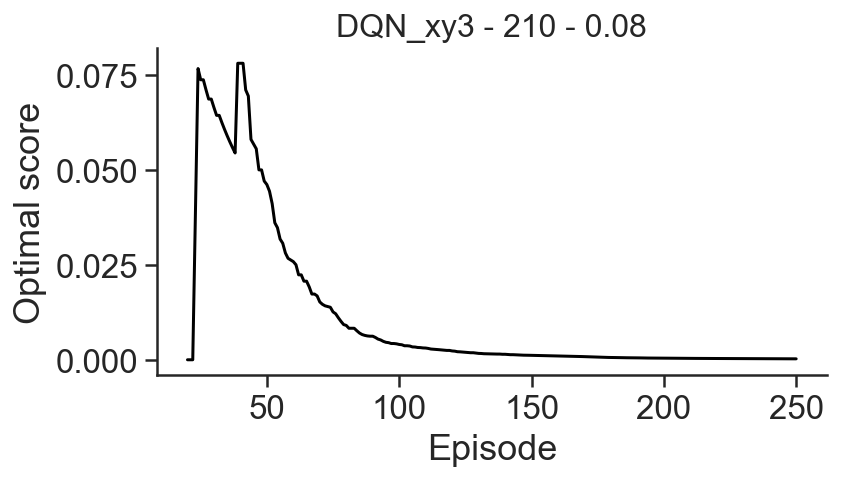

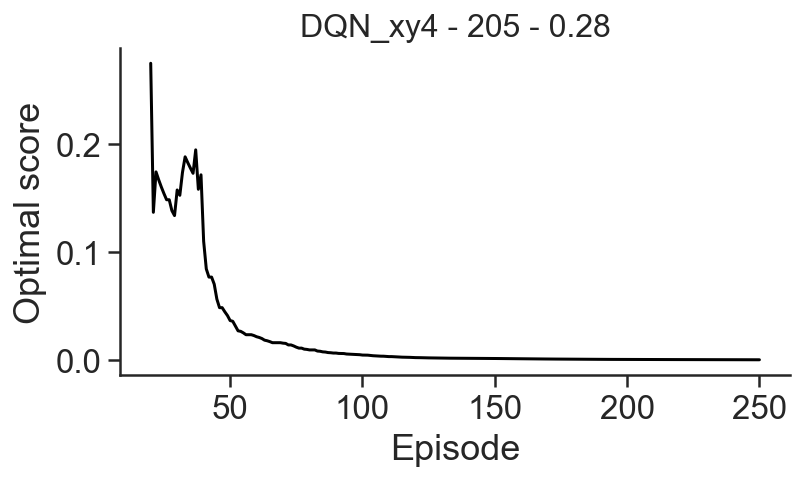

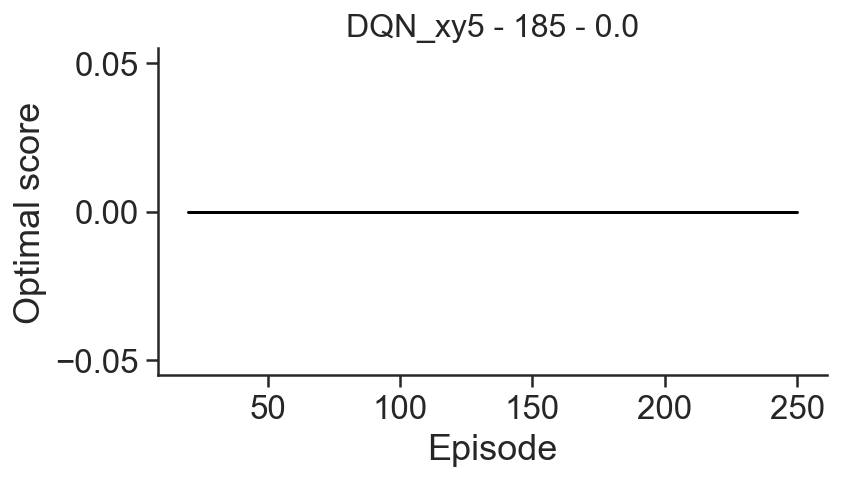

In [48]:
worst_rows = [200, 76, 210, 205, 185]
for row, model in zip(worst_rows, models):
    exp_65 = load_data(path, model, run_index=index)
    plt.figure(figsize=(6, 3))
    mon = exp_65[row]
    _ = plt.plot(mon['episode'], mon['score'], color='black', alpha=1)
    _ = plt.title(f"{model} - {row} - {np.max(mon['score']).round(2)}")
    _ = plt.ylabel("Optimal score")
    _ = plt.xlabel("Episode")
    sns.despine()

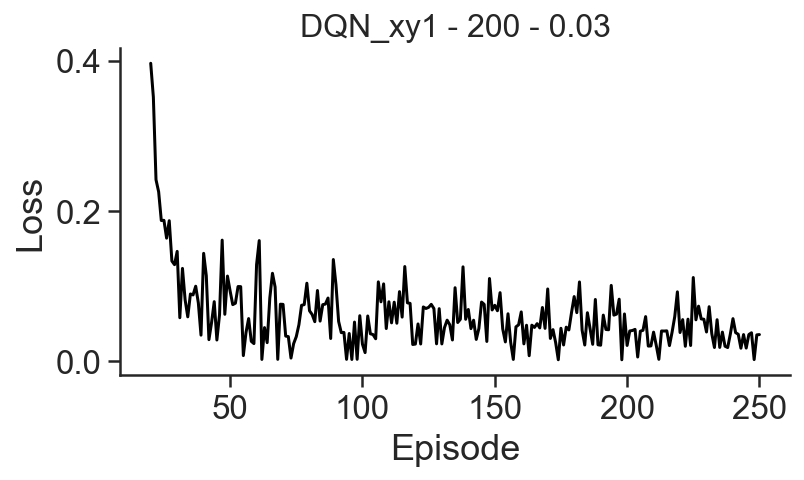

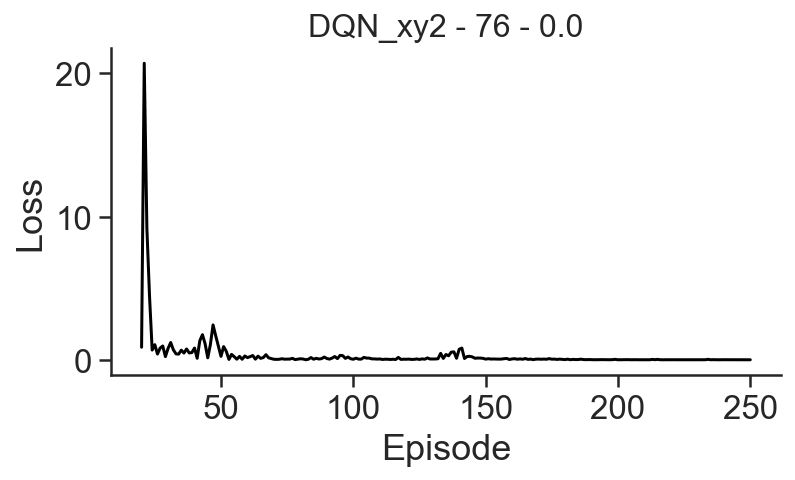

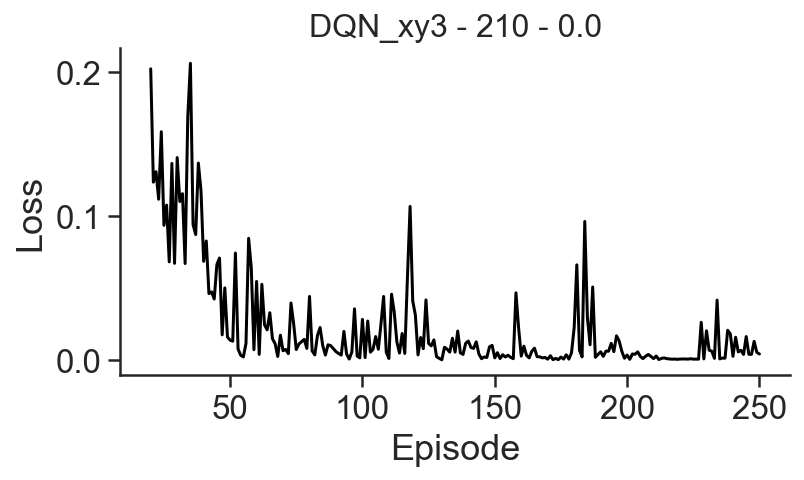

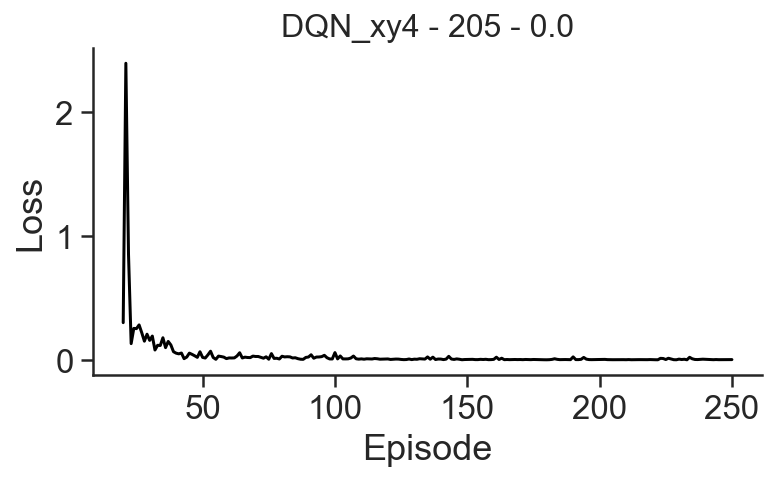

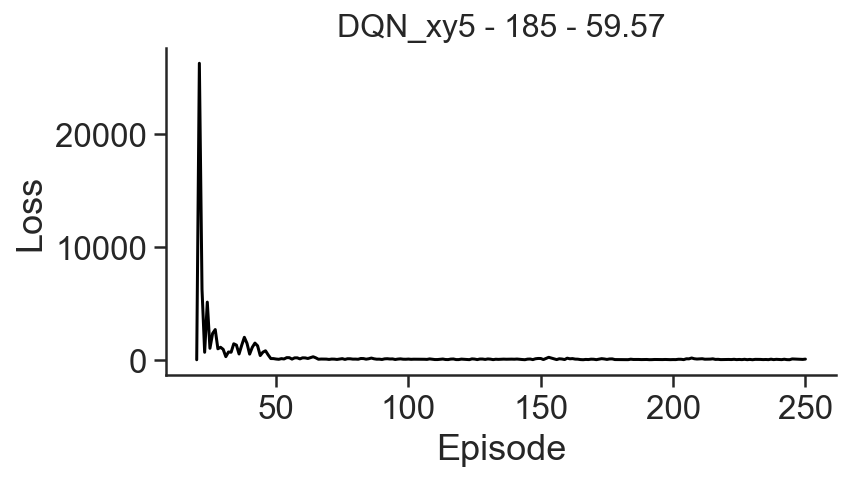

In [49]:
worst_rows = [200, 76, 210, 205, 185]
for row, model in zip(worst_rows, models):
    exp_65 = load_data(path, model, run_index=index)
    plt.figure(figsize=(6, 3))
    mon = exp_65[row]
    _ = plt.plot(mon['episode'], mon['loss'], color='black', alpha=1)
    _ = plt.title(f"{model} - {row} - {np.round(mon['loss'][-1],2)}")
    _ = plt.ylabel("Loss")
    _ = plt.xlabel("Episode")
#     _ = plt.ylim(0, 10)
    sns.despine()